In [1]:
import random
import torch.nn.functional as F
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch.optim as optim
from unityagents import UnityEnvironment
import torch.nn as nn


env = UnityEnvironment(file_name="Tennis.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
states = env_info.vector_observations
action_size = brain.vector_action_space_size
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
#standard Actor and Critic NNs:

def hidden_init(layer):
    # source: The other layers were initialized from uniform distributions
    # [− 1/sqrt(f) , 1/sqrt(f) ] where f is the fan-in of the layer
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)
    
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, rand_seed, fc1_units=30,
                 fc2_units=30):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fc1_units: int. Number of nodes in first hidden layer
        :param fc2_units: int. Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(rand_seed)
        # source: The low-dimensional networks had 2 hidden layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc1))
        # source: The final layer weights and biases of the actor and were
        # initialized from a uniform distribution [−3 × 10−3, 3 × 10−3]
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        """
        # source: used the rectified non-linearity for all hidden layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # source The final output layer of the actor was a tanh layer,
        # to bound the actions
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, full_state_size, rand_seed, fcs1_units=50, 
                 fc2_units=50):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fcs1_units: int. Nb of nodes in the first hiddenlayer
        :param fc2_units: int. Nb of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(rand_seed)
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """
        Build a critic (value) network that maps
        (state, action) pairs -> Q-values
        :param state: tuple.
        :param action: tuple.
        """
        xs = F.relu(self.fcs1(state))
        x = F.relu(self.fc2(xs))
        return self.fc3(x)

#Bringing everything together, the main network for the algorithm:
    
class GaussianActorCritic(nn.Module):
    def __init__(self, state_size, action_size, full_state_size, activation=F.relu):
        super().__init__()
        self.std = torch.nn.Parameter(torch.ones(1, action_size))
        self.actor = Actor(state_size, action_size, rand_seed=2)
        self.critic = Critic(full_state_size, rand_seed=2)
    
    def forward(self, state, action=None):
        mean = torch.tanh(self.actor(state))
        dist = torch.distributions.Normal(mean, self.std)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action, log_prob

    def criticvalue(self, full_state):
        return self.critic(full_state)
    

In [3]:
class PPOagent():
    
    def __init__(self, network, device, 
                 LR,
                 WEIGHT_DECAY,
                 grad_clip, 
                 EPOCHS, 
                 BATCH_SIZE,
                GAMMA,
                GAE_TAU,
                CLIP_EPSILON,
                C1,
                C2):
        self.device = device
        self.network = network
        self.optim = optim.Adam(self.network.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        self.grad_clip = grad_clip
        self.EPOCHS=EPOCHS 
        self.BATCH_SIZE=BATCH_SIZE
        self.GAMMA=GAMMA
        self.CLIP_EPSILON=CLIP_EPSILON
        self.GAE_TAU=GAE_TAU
        self.C1=C1
        self.C2=C2
    
    def act(self, states):
        with torch.no_grad():
            states = torch.tensor(states).float().to(self.device)
            actions, log_probs = self.network(states)
        return actions.cpu().detach().numpy(), log_probs.cpu().detach().numpy()

    def learn(self, states, actions, log_probs, values, rewards, next_states, dones, full_states, next_values):
     
        states = torch.tensor(states, device=self.device, dtype=torch.float32, requires_grad=False)
        actions = torch.tensor(actions, device=self.device, dtype=torch.float32, requires_grad=False)
        log_probs = torch.tensor(log_probs, device=self.device, dtype=torch.float32, requires_grad=False)
        values = torch.tensor(values, device=self.device, dtype=torch.float32, requires_grad=False)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32, requires_grad=False)
        next_states = torch.tensor(next_states, device=self.device, dtype=torch.float32, requires_grad=False)
        dones = 1 - torch.tensor(dones, device=self.device, dtype=torch.float32, requires_grad=False)
        full_states = torch.tensor(full_states, device=self.device, dtype=torch.float32, requires_grad=False)
        next_values = torch.tensor(next_values, device=self.device, dtype=torch.float32, requires_grad=False)
        returns = next_values[-1]

        #calculating advantages, using generalized advantage estimation (GAE):
        advantages = [None] * actions.shape[0]
        returns_array = [None] * actions.shape[0]  
        advantage = torch.zeros(rewards[0].shape, device=self.device, dtype=torch.float32)
        
        for i in reversed(range(states.shape[0])):
            returns = rewards[i] + self.GAMMA*returns*dones[i]
            returns_array[i]=returns.unsqueeze(0).detach()
            
            td_error = rewards[i] + self.GAMMA * dones[i] * next_values[i] - values[i]
            advantage = advantage * self.GAE_TAU * self.GAMMA * dones[i] + td_error
            
            advantages[i] = advantage.unsqueeze(0).detach()

        returns_array = torch.cat(returns_array, dim=0)
        advantages = torch.cat(advantages, dim=0).unsqueeze(-1)
        advantages = (advantages - advantages.mean()) / advantages.std()
        
        
        # for training:
        for epoch in range(self.EPOCHS):
            for indices in self.batch_indices(len(states), self.BATCH_SIZE):
                i = torch.tensor(indices).long()
                sampled_states = states[i] 
                sampled_full_states = full_states[i]
                sampled_actions = actions[i]    
                sampled_log_probs = log_probs[i].detach() 
                sampled_advantages = advantages[i] 
                sampled_returns = returns_array[i].detach()
                
                new_log_probs = self.network(sampled_states, sampled_actions)[1]
                ratio = (new_log_probs - sampled_log_probs).exp()
                clip = torch.clamp(ratio, 1-self.CLIP_EPSILON, 1+self.CLIP_EPSILON)
                clipped_surrogate = torch.min(ratio*sampled_advantages, clip*sampled_advantages)
                entropy = -(new_log_probs.exp()*new_log_probs) 
                critic_values = self.network.criticvalue(sampled_full_states).squeeze(-1)
                value_loss = F.mse_loss(critic_values, sampled_returns)
                
                self.optim.zero_grad()
                value_loss = value_loss.unsqueeze(-1)
                total_loss = - (clipped_surrogate - self.C1 * value_loss + self.C2 * entropy).mean()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.grad_clip)
                self.optim.step()

        
    def criticvalues(self, full_states):
        with torch.no_grad():
            full_states = torch.tensor(full_states).float().to(self.device)
            cv = self.network.criticvalue(full_states)
        return cv.cpu().detach().numpy()
    
#Simple impementation of batch indices for training by Kotogasy

    def batch_indices(self, length, batch_size):
        indices = np.arange(length)
        np.random.shuffle(indices)
        for i in range(1 + length // batch_size):
            start = batch_size*i
            end = start + batch_size
            end = min(length, end)
            if start >= length:
                return
            yield indices[start:end]

In [4]:
def train(agent, episodes, train_mode=True):
    scores = []                      
    scores_window = deque(maxlen=100) 
    for i_episode in range(1, episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_one_episode = np.zeros(2)
        trajectories_states, trajectories_next_states, trajectories_full_states, trajectories_actions, \
        trajectories_log_probs, trajectories_values, trajectories_rewards, \
        trajectories_dones = [], [], [], [], [], [], [], []
        
        while True:
            actions, log_probs = agent.act(states)
            trajectories_states.append(states)
            trajectories_actions.append(actions)
            trajectories_log_probs.append(log_probs)            
           
        
            env_info = env.step(np.clip(actions, -1, 1))[brain_name]    
            next_states = env_info.vector_observations    
            rewards = env_info.rewards                        
            dones = env_info.local_done                                          
            scores_one_episode += rewards
            
            #for training:
            
            #Really clever implementation by Kodogasy of concatenating (s,a) from both tennis paddles into single full state:
            # Concatenate all states and actions taken by all agents into 'full_state'
            # from agent 0 point of view, concatenate state seen by agent 0, state seen by agent 1, action agent 0, action agent 1
            # from agent 1 point of view, concatenate state seen by agent 1, state seen by agent 0, action agent 1, action agent 0
            
            full_state = np.zeros((num_agents, (state_size + action_size) * num_agents))
            for i in range(num_agents):
                start = 0
                start_action = state_size * num_agents
                idx = np.arange(num_agents)
                for j in idx:
                    full_state[i][start:start + state_size] += states[j]
                    full_state[i][start_action: start_action + action_size] += actions[j]
                    start += state_size
                    start_action += action_size
            
            trajectories_full_states.append(full_state)
            trajectories_values.append(agent.criticvalues(full_state).squeeze(-1))
            trajectories_next_states.append(next_states)
            trajectories_rewards.append(rewards)
            trajectories_dones.append(dones)  
            states = next_states                                    
            if np.any(dones):                           
                break
                
        #end of episode, training the agent with all on-policy gathered trajectories:
        
        trajectories_next_values = trajectories_values.copy()
        for i in range(len(trajectories_next_values)):
            trajectories_next_values[i] = trajectories_next_values[i].copy()    
        # ensure that the next value of timestep i is the value of timestep i+1           
        trajectories_next_values = np.roll(np.array(trajectories_next_values), -1, axis=0)
        trajectories_next_values[-1]=0

        agent.learn(trajectories_states, 
            trajectories_actions, 
            trajectories_log_probs, 
            trajectories_values, 
            trajectories_rewards, 
            trajectories_next_states,
            trajectories_dones, 
            trajectories_full_states, 
            trajectories_next_values)
        
        #score defined by Udacity for solving purposes:
        score = np.max(scores_one_episode)
        scores.append(score)
        scores_window.append(score)
        mean_100 = np.mean(scores_window)

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}\tLast Score: {:.3f}'.
                      format(i_episode, 
                         mean_100, 
                         np.max(scores_window),
                        scores_window[-1]))
            torch.save(network.state_dict(),"eps_{}_avg_{}.pth".format(i_episode, mean_100))
            
        if len(scores_window) >= 100 and np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, mean_100))
            torch.save(network.state_dict(),"final.pth")
            break
    return scores

Episode 50	Average Score: 0.024	Max Score: 0.100	Last Score: 0.000
Episode 100	Average Score: 0.018	Max Score: 0.100	Last Score: 0.000
Episode 150	Average Score: 0.012	Max Score: 0.100	Last Score: 0.000
Episode 200	Average Score: 0.015	Max Score: 0.200	Last Score: 0.000
Episode 250	Average Score: 0.017	Max Score: 0.200	Last Score: 0.100
Episode 300	Average Score: 0.018	Max Score: 0.200	Last Score: 0.000
Episode 350	Average Score: 0.018	Max Score: 0.200	Last Score: 0.000
Episode 400	Average Score: 0.013	Max Score: 0.100	Last Score: 0.000
Episode 450	Average Score: 0.010	Max Score: 0.100	Last Score: 0.000
Episode 500	Average Score: 0.016	Max Score: 0.100	Last Score: 0.000
Episode 550	Average Score: 0.021	Max Score: 0.190	Last Score: 0.000
Episode 600	Average Score: 0.019	Max Score: 0.190	Last Score: 0.000
Episode 650	Average Score: 0.017	Max Score: 0.100	Last Score: 0.000
Episode 700	Average Score: 0.020	Max Score: 0.200	Last Score: 0.000
Episode 750	Average Score: 0.021	Max Score: 0.200

Episode 6050	Average Score: 0.034	Max Score: 0.200	Last Score: 0.100
Episode 6100	Average Score: 0.035	Max Score: 0.200	Last Score: 0.000
Episode 6150	Average Score: 0.030	Max Score: 0.200	Last Score: 0.000
Episode 6200	Average Score: 0.031	Max Score: 0.200	Last Score: 0.090
Episode 6250	Average Score: 0.043	Max Score: 0.200	Last Score: 0.000
Episode 6300	Average Score: 0.038	Max Score: 0.200	Last Score: 0.000
Episode 6350	Average Score: 0.030	Max Score: 0.200	Last Score: 0.000
Episode 6400	Average Score: 0.043	Max Score: 0.300	Last Score: 0.000
Episode 6450	Average Score: 0.053	Max Score: 0.400	Last Score: 0.100
Episode 6500	Average Score: 0.040	Max Score: 0.400	Last Score: 0.090
Episode 6550	Average Score: 0.031	Max Score: 0.100	Last Score: 0.090
Episode 6600	Average Score: 0.033	Max Score: 0.200	Last Score: 0.000
Episode 6650	Average Score: 0.035	Max Score: 0.200	Last Score: 0.000
Episode 6700	Average Score: 0.035	Max Score: 0.200	Last Score: 0.000
Episode 6750	Average Score: 0.032	

Episode 12000	Average Score: 0.042	Max Score: 0.200	Last Score: 0.190
Episode 12050	Average Score: 0.043	Max Score: 0.300	Last Score: 0.200
Episode 12100	Average Score: 0.048	Max Score: 0.300	Last Score: 0.000
Episode 12150	Average Score: 0.043	Max Score: 0.300	Last Score: 0.000
Episode 12200	Average Score: 0.045	Max Score: 0.300	Last Score: 0.000
Episode 12250	Average Score: 0.053	Max Score: 0.200	Last Score: 0.000
Episode 12300	Average Score: 0.053	Max Score: 0.200	Last Score: 0.000
Episode 12350	Average Score: 0.052	Max Score: 0.400	Last Score: 0.100
Episode 12400	Average Score: 0.049	Max Score: 0.400	Last Score: 0.000
Episode 12450	Average Score: 0.049	Max Score: 0.200	Last Score: 0.000
Episode 12500	Average Score: 0.050	Max Score: 0.200	Last Score: 0.000
Episode 12550	Average Score: 0.042	Max Score: 0.200	Last Score: 0.000
Episode 12600	Average Score: 0.047	Max Score: 0.300	Last Score: 0.200
Episode 12650	Average Score: 0.053	Max Score: 0.300	Last Score: 0.100
Episode 12700	Averag

Episode 17900	Average Score: 0.062	Max Score: 0.300	Last Score: 0.090
Episode 17950	Average Score: 0.065	Max Score: 0.200	Last Score: 0.100
Episode 18000	Average Score: 0.068	Max Score: 0.400	Last Score: 0.100
Episode 18050	Average Score: 0.065	Max Score: 0.400	Last Score: 0.100
Episode 18100	Average Score: 0.061	Max Score: 0.300	Last Score: 0.090
Episode 18150	Average Score: 0.063	Max Score: 0.300	Last Score: 0.000
Episode 18200	Average Score: 0.066	Max Score: 0.500	Last Score: 0.100
Episode 18250	Average Score: 0.074	Max Score: 0.500	Last Score: 0.000
Episode 18300	Average Score: 0.076	Max Score: 0.400	Last Score: 0.100
Episode 18350	Average Score: 0.070	Max Score: 0.400	Last Score: 0.100
Episode 18400	Average Score: 0.076	Max Score: 0.300	Last Score: 0.100
Episode 18450	Average Score: 0.076	Max Score: 0.500	Last Score: 0.090
Episode 18500	Average Score: 0.068	Max Score: 0.500	Last Score: 0.000
Episode 18550	Average Score: 0.068	Max Score: 0.400	Last Score: 0.000
Episode 18600	Averag

Episode 23800	Average Score: 0.094	Max Score: 0.500	Last Score: 0.000
Episode 23850	Average Score: 0.119	Max Score: 0.600	Last Score: 0.000
Episode 23900	Average Score: 0.150	Max Score: 0.600	Last Score: 0.090
Episode 23950	Average Score: 0.145	Max Score: 0.700	Last Score: 0.090
Episode 24000	Average Score: 0.130	Max Score: 0.700	Last Score: 0.000
Episode 24050	Average Score: 0.125	Max Score: 0.700	Last Score: 0.100
Episode 24100	Average Score: 0.135	Max Score: 0.800	Last Score: 0.100
Episode 24150	Average Score: 0.120	Max Score: 0.800	Last Score: 0.000
Episode 24200	Average Score: 0.121	Max Score: 0.500	Last Score: 0.200
Episode 24250	Average Score: 0.144	Max Score: 0.800	Last Score: 0.200
Episode 24300	Average Score: 0.150	Max Score: 0.800	Last Score: 0.100
Episode 24350	Average Score: 0.142	Max Score: 0.800	Last Score: 0.000
Episode 24400	Average Score: 0.132	Max Score: 0.800	Last Score: 0.000
Episode 24450	Average Score: 0.127	Max Score: 0.700	Last Score: 0.090
Episode 24500	Averag

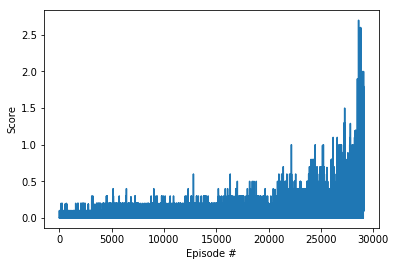

In [5]:
seed = 30
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

network = GaussianActorCritic(state_size, action_size, (state_size + action_size)*2 ).to(device)
agent = PPOagent(network, device,  
                 LR=1e-4,
                 WEIGHT_DECAY=1e-4,
                 grad_clip=5, 
                 EPOCHS=7, 
                 BATCH_SIZE=300,
                GAMMA=0.999,
                GAE_TAU=0.9,
                CLIP_EPSILON=0.1,
                C1=0.4,
                C2=0.01)

scores = train(agent, episodes=40000, train_mode=True)

def plot_result(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
plot_result(scores)